<center><img src="logo.png" alt="logo" style="float:center; width:200px;"/></center>

<center><h1 style="color:rgb(49,112,223);"> Interactive Decision Trees</h1><\center>

# 

# Using Interactive Decision Trees to improve DT interpretability by finding physically meaningful connections of the DT output with other relevant scientific knowledge sources.

In this JupyterLab notebook we show how experts can manually change nodes thresholds to split. We demonstrate how this functionality of the iDTs toolbox could be used to icorporate scientific knowledge into DT and achieve higher intertpretability of the DT. The methodology described in this JupyterLab notebook was followed to produce the results of the 2nd case study of the paper *Integrating Scientific Knowledge into Machine Learning using Interactive Decision Trees (Sarailidis et al. 2021, EMS)*.

# Notebook Contents:

1. Introduction
    + 1.1 Description of the initial dataset
    + 1.2 Objective of the case study
    + 1.3 Holdridge's Life zones classification scheme
2. Create sample datasets of various sizes through Random Sampling from the initial dataset
3. Derive the Statistically Optimal Tree (SOT)
4. Derive interactive DT (iDT)
    + Manually change the nodes thresholds
    + Manually prune nodes
5. Evaluation of SOT and iDT perfomance
6. References

# 1. Introduction:

## 1.2 Objective of the case study 
This case study is an example which shows the usefulness of iDTs for finding meaningful interpretation of the DT outcome in relation to other relevant scientific information. More specifically, in this case study we  want to understand how various recharge classes can be mapped into climatic zones. For this purpose, we derive statistically optimal DT (SOT) and interactive DT (iDT) for 15 different random samples and we look at how the leaves nodes (recharge classes) of each DT are mapped into life zones in Holdridge's chart. We show that iDTs which incorporate scientific knowledge map recharge classes to climatic zones more concisely.

## 1.1 Description of the initial dataset:

We used the dataset from Sarazin (2018): 

- The dataset contains 17,000,000 simulations (data points) of a hydrological model and 34 input variables which characterize climate properties and land cover types. 
- There are 4 classes in the dataset, namely, C1 (<20 mm/yr), C2 (20 – 100 mm/yr), C3 (100 – 300 mm/yr) and C4 (>300 mm/yr) which correspond to different recharge values.
- A DT algorithm applied to this dataset shows how the different input factors combine to produce more or less recharge. 

## 1.3 Holdridge's life zones classification scheme 
We use a simplified version of the Holdridge life zones classification scheme. It is a triangle chart for classifying land areas based on precipitation and aridity index (ratio between potential evaporation and precipitation) (for more information on the Holdridge chart follow the link https://en.wikipedia.org/wiki/Holdridge_life_zones ). Our simplified Holdridge life zone classification scheme is shown in the following figure: 

<center><img src="Holdridges_chart_modified.png"></center>


# 2. Create sample datasets of various sizes through Random Sampling from the initial dataset

The 15 sample datasets of various sizes mentioned above were created using the GUI for importing files we developed and it's included in iDTGUIfun module. It contains an implementation for random sampling and splitting in train and test sets. To ease reproducibility, in the rest of this notebook I will use the sample datasets I derived (and which are provided in the folder 'Sample_dataset') to produce the results of the 2nd case study of the paper *Integrating Scientific Knowledge into Machine Learning using Interactive Decision Trees Sarailidis et al. (2021) submitted in EMS (under review)

__Note:__ If interested to know how to use the import file GUI please look at the "How to use the Graphical User Interface" pdf I provide in the repository and the 1st_case_study Workflow.

Import necessary Libraries & Modules

In [1]:
#Import library for random sampling
import random
#Import modules for interactive construction and analysis of DT
import InteractiveDT
from InteractiveDT import iDT
from InteractiveDT import iDTGUIfun

#Libraries which are useful for many cases
import pandas as pd
import numpy as np
#Libraries necessary for data analysis and ML methods
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
#Libraries useful for finding the statistiaclly optimal trees
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from time import time
#Libraries useful for measuring the classification accuracy and creating confusion matrices
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Libraries necessary for producing the plots
from plotly.subplots import make_subplots
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'InteractiveDT'

Initialize the GUI:

In [5]:
#The next three empty dictionaries we create are required as inputs for the initialization of the GUI
Data_dict={}
Classes_color_dict={'Classes Labels': {}, 'Classes Colors': {}}
Features_color_groups={'Groups & parameters': {}, 'Colors of groups': {}}
#Initialize the GUI:
GUI = iDTGUIfun.InteractiveDecisionTreesGUI(Data_dict, Classes_color_dict, Features_color_groups)

Load the corresponding dataset:

In [8]:
#Specify the input files path

path_train_inputs = r'Sample_datasets\4. Random_seed_5562000\Training_input_1000_rs_5562000'
path_train_outputs = r'Sample_datasets\4. Random_seed_5562000\Training_output_1000_rs_5562000'
path_test_inputs = r'Sample_datasets\4. Random_seed_5562000\Test_input_1000_rs_5562000'
path_test_outputs = r'Sample_datasets\4. Random_seed_5562000\Test_output_1000_rs_5562000'

#Train Inputs 
GUI.Data_dict['x'] = pd.read_pickle(path_train_inputs)
#Train Outputs
GUI.Data_dict['y'] = pd.read_pickle(path_train_outputs)
#Test Inputs
GUI.Data_dict['z'] = pd.read_pickle(path_test_inputs)
#Test Outputs
GUI.Data_dict['w'] = pd.read_pickle(path_test_outputs)

#Complete output dataset
GUI.Data_dict['outputs_complete_dataset']=pd.concat([GUI.Data_dict['y'], GUI.Data_dict['w']])
#Complete inputs dataset
GUI.Data_dict['inputs_complete_dataset']=pd.concat([GUI.Data_dict['x'], GUI.Data_dict['z']])
#Outputs train dataset
GUI.Data_dict['outputs_train']=GUI.Data_dict['y']
#List of the available features (variables) in the dataset 
GUI.Data_dict['features']=list(GUI.Data_dict['x'].columns)

Now we need to create the dictionary that will store the classes names and the corresponding colours. We use the DefineClassesGUI for this purpose. 

In the GUI that will appear:

+ Type the name of the class in the correspodning text area widget that will appear.
     - The names of the classes should be the same as the ones included in the csv file we imported. For this example the classes names are: C1, C2, C3, C4
+ Click the 'Add Class Label' button
+ Click on the colored box to open the color picker box. Pick a color and click ok. Or, type the name of the colour in the corresponding text area of the widget. 
+ Click the 'Assign color to the Class' button

In [9]:
GUI.DefineClassesGUI()
GUI.classes_labels_box

__Note:__ If someone wants to see the loaded classes and colours then in a new cell type GUI.classes_dict and run the cell. This will output a dictionary which stores key-value pairs of classes labels and classes colours.

# 3. Derive the Statistically Optimal Tree (SOT)

To derive the SOT for each sample dataset we use the Exhaustive Grid Search from sklearn library (for more details: https://scikit-learn.org/0.15/modules/grid_search.html ).

1. We set up the parameter space grid with the following parameters (and their ranges):

    + Criterion: [gini, entropy]
    + Max_leaf_nodes: [15:26 (or 30 in large samples), step=1]
    + Min_impurity_decrease: [10^-5, 10^-6, 10^-7]


2. We set a 10-fold Cross validation search

In Exhaustive Grid Search all the possible combinations of parameter values are evaluated, and the best combination is retained.

In [10]:
#Create a Decision Tree classifier object
dtc = sklearn.tree.DecisionTreeClassifier(random_state=None)
#Set the parameter range for the maximum leaf nodes parameter
max_leaf_nodes_range=list(range(10,25,1))

#Set up the parameters grid
parameter_grid = {'max_leaf_nodes': max_leaf_nodes_range,
                  'criterion': ['gini', 'entropy'],
                  'min_impurity_decrease': [0.0000001,0.000001, 0.00001]}
# Specify the validation strategy
cross_validation = StratifiedKFold(n_splits=10)

#Exhaustive GridSearch
grid_search = GridSearchCV(dtc, param_grid=parameter_grid, cv=cross_validation, n_jobs=-1, error_score='raise')
grid_search.fit(GUI.Data_dict['x'], GUI.Data_dict['y'])
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

#Store the stat. optimal combination found in a variable
dtc_estimator = grid_search.best_estimator_
dtc_estimator

Best score: 0.7506666666666668
Best parameters: {'criterion': 'gini', 'max_leaf_nodes': 12, 'min_impurity_decrease': 1e-06}


DecisionTreeClassifier(max_leaf_nodes=12, min_impurity_decrease=1e-06)

# 

__Τo obtain the SOT in the GUI that will appear the user needs to specify the above optimal values for criterion, max_leaf_nodes and min_impurity_decrease (criterion = entropy, max_leaf_nodes = 15, min_impurity_decrease = 10^-6) using the corresponding widgets.__

__Note_1:__ Once the user changes the value of one of 'Decision Tree Structure Controlling Parameters and Plot Formatting' widgets the DT plot will be automatically updated.

__Note_2:__ The max_depth widget value shoulde be set to a high enough value (e.g. 10) to ensure that the 15 leaf nodes will be plotted. Moreover, the max_features widget value should be set equal to number of features available in the dataset (in this case 34) in order for the algorithm to be able to choose among all of them.

In [11]:
#Initialize the GUI that contains widgets for interactive construction and analysis of DT
GUI.InterConAnalDTGUI()

#For the update Features button to work we need to initialize the GUI SelectFeaturesGUI.
GUI.SelectFeaturesGUI() 

#Output the widgets:
GUI.Box

interactive(children=(Dropdown(description='criterion', layout=Layout(width='20%'), options=('gini', 'entropy'…

VBox(box_style='info', children=(VBox(children=(HBox(children=(Label(value='Creation of New Composite Variable…

# 4. Derive interactive DT

### 4.1 Manually Change nodes thresholds

Our first interaction with the DT is to manually change nodes thresholds. We manually change the Precipitation and Aridity Index thresholds that appear on the SOT according to the Holdridge chart thresholds. We assume that the threshold values of the DT as derived by the algorithm are optimal, but these are not necessarily physically meaningful. On the contrary, the thresholds appearing in the Holdridge chart represent the accumulated, scientific knowledge and are physically meaningful values. For example, a change could be of the form: Node 1: from Pm<=229.815 to Pm<=250. We don't change the thresholds in the root node because otherwise it would be like manually building the DT from scratch

How to manually change nodes feaures and threshold to split using the GUI?

1. In the widget 'Node_id', specify the id of the node which its threshold needs to be changed. The user can see the nodes IDs by hovering over the nodes in the plot (a window displaying the ID, the impurity and the nodes samples appears).
2. Select the variable to split from the dropdown menu of the widget named 'Features'.
3. Specify the new threshold value in the widget named 'Split Point'
4. Specify the max_leaf_nodes the left subtree should have 'Max_leaf_nodes_right_subtree'
5. Specify the max_leaf_nodes the right subtree should have in the widget named 'Max_leaf_nodes_right_subtree'   
6. Press the button widget 'Apply Changes'.
  
__Note_1:__ If we want to make changes to a node which in the original SOT one of its barnches leads to a leaf node e.g. left branch, then for this node for the left_subtree we need to specify max_leaf_nodes_left_subtree = 2, because otherwise the program won't work. Then, we can manually prune that node if we want to force it to have one leaf_node as in the original SOT.__

We repeat steps 1 to 6 until we are happy. In this case study we make the following changes in the following order:

1. Node 1:  From Pm <= 229.815 to Pm <= 250  (Max_leaf_nodes_left_subtree = 4, Max_leaf_nodes_right_subtree = 6)
2. Node 10: From Pm <= 527.535 to Pm <= 500  (Max_leaf_nodes_left_subtree = 3, Max_leaf_nodes_right_subtree = 2)
3. Node 3:  From Pm <= 79.139  to Pm <= 125  (Max_leaf_nodes_left_subtree = 2, Max_leaf_nodes_right_subtree = 2) 
4. Node 7:  From Pm <= 1008.85 to Pm <= 1000 (Max_leaf_nodes_left_subtree = 2, Max_leaf_nodes_right_subtree = 2)
5. Node 10: From AI <= 1.604   to AI <= 2    (Max_leaf_nodes_left_subtree = 2, Max_leaf_nodes_right_subtree = 2)

__Note:__ Everytime we make a change to a node and we press the 'Apply Changes' button the nodes numbering will be updated in the derived tree. So in the above list the node ids refer to the last modified tree.

### 4.2 Manual Pruning

Then we manually prune nodes that we consider less informative or redundant. For example, sometimes a split might lead to leaves nodes of the same class. This could be a bit confusing. The classes of a leaf node are determined based on majority rule. The leaf node will be assigned with the class that contains the most data points. If we make further splits on such nodes we will get a different class. But the more splits we make the higher the risk of overfitting and then our DT could not genralize well. So, we manually prune these nodes. 
 
To manually prune nodes using the GUI we follow the steps:

1. Check the 'Tree is Modified' widget because we previously modified the DT by manually changing the threshold values.
2. Specify node id to be pruned in the 'Node to prune' widget
3. Press the 'Prune' button

We repeat steps 2 to 3 until we are happy. In this case study we prune the following nodes in the following order:

1. Node: 16 (of the last modified tree)
2. Node: 38
3. Node: 24
4. Node: 30
5. Node: 17

__Note:__ Everytime we make a change to a node and we press the 'Prune' button the nodes numbering will be updated in the derived tree. In the above list the node ids in steps 2 to 5 refer to the last pruned tree.


In [12]:
#Initialize the GUI that contains widgets for interactive construction and analysis of DT
GUI.InterConAnalDTGUI()

#For the update Features button to work we need to initialize the GUI SelectFeaturesGUI.
GUI.SelectFeaturesGUI() 

#Output the widgets:
GUI.Box

interactive(children=(Dropdown(description='criterion', layout=Layout(width='20%'), options=('gini', 'entropy'…

VBox(box_style='info', children=(VBox(children=(HBox(children=(Label(value='Creation of New Composite Variable…

# 5. Evaluation of SOT and iDTs perfomace

The SOT and iDTs derived for the 15 different sample datasets are evaluated based on:

1. Their classification accuracy on train and test sets
2. Their interpretability. To quantify DT interpretability we measure the number of Holdridge life zones diamonds that each leaf can be mapped to. We assume that mapping each recharge class in fewer land area types is more informative and helpful for the expert.  Therefore, the fewer the diamonds a leaf is mapped to the better.

#### Assessment of the classification performance

In the GUI that will appear the user should:

+ Specify the tree state using the dropdown widget:
    - If there were no previous interactions with the DT then the user should select the 'No expert tree interactions'. By selecting this, the accuracies for the SOT will be calculated.
    - If the last interaction with the DT was manual changing of variable and/or threshold to split then the user should select the option 'Tree was last modified'
    - If the last interaction with the DT was manual pruning then the user needs to select the option 'Tree was last pruned'. By selecting this, the accuracies for the iDT will be calculated.
+ Make sure the 'Train_test_splitting' is checked.
+ Then click on the 'Calculate accuracy' button (In the case of iDT it will take few minutes)

In [13]:
#Output the evaluation widgets
GUI.Eval_box

VBox(box_style='info', children=(VBox(box_style='info', children=(HBox(box_style='info', children=(Dropdown(de…

#### Assessment of interpretability of DT:

For each leaf node (in both trees) we follow the rules and apply them to the Holdridge chart and measure the number of diamonds this node falls into. The fewer the diamonds the better. For example:
    
 + SOT:
   + The Node 25 tree rules are Pm<=681.345 and Pm<=229.815 and h_veg <=10.315 and Pm<=527.535 and Wsm <=4.366. For Holdridge chart only Pm and AI splits are relevant. Therefore, this leaf node corresponds to all the diamonds that satisfy the conditions Pm>229.815 and Pm<=527.535. So, this node can fall to either of the 17 diamonds shown in the following figure:

        <img style="width:50px; height=10px; float: center;" src="Sample_datasets\4. Random_seed_5562000\HC_SOT_Pm_229_527.png">

    + The Node 26 tree rules are Pm<=681.345 and Pm<=229.815 and h_veg<=10.315 and Pm<=527.535 and Wsm>4.366. Therefore, this leaf node corresponds to all the diamonds that satisfy the conditions Pm>229.815 and Pm<=527.535. So, this node can fall to either of the 17 diamonds shown in the above figure.
   
 + iDT:
     + The Node 28 tree rules are Pm<=681.345 and Pm>250 and r_st<=157.955 and Pm<=500 and AI<=2.00. Therefore, this leaf node corresponds to all the diamonds that satisfy the conditions Pm<=250 and Pm<500 and AI<=2.00. So, this node can fall to either of the 4 diamonds shown in the following figure:
     
          <img style="float: center;" src="Sample_datasets\4. Random_seed_5562000\HC_INT_Pm[250,500]_AI[0,2].png">
     
     + The Node 30 tree rules are Pm<=681.345 and Pm>250 and r_st<=157.955 and Pm<=500 and AI>2.00 and a<=3.028. Therefore, this leaf node corresponds to all the diamonds that satisfy the conditions Pm>250 and Pm<=500 and AI<=2.00. So, this node can fall to either of the 2 diamonds shown in the following figure:
     
          <img style="float: center;" src="Sample_datasets\4. Random_seed_5562000\HC_INT_Pm[250,500]_AI[2,].png">
     
     + The Node 31 tree rules are Pm<=681.345 and Pm>250 and r_st<=157.955 and Pm<=500 and AI>2.00 and a>3.028. Therefore, this leaf node corresponds to all the diamonds that satisfy the conditions Pm>500 and AI<=2.00. So, this node can fall to either of the 2 diamonds shown in the above figure.           

We specified the number of diamonds for each leaf node of the DT and stored this information in tables (which are provided in https://github.com/Sarailidis/Interactive-Decision-Trees/tree/main/Workflows/2nd_case_study ). Now, it is possible to estimate the average number of diamonds each class of the DT can be mapped to: 

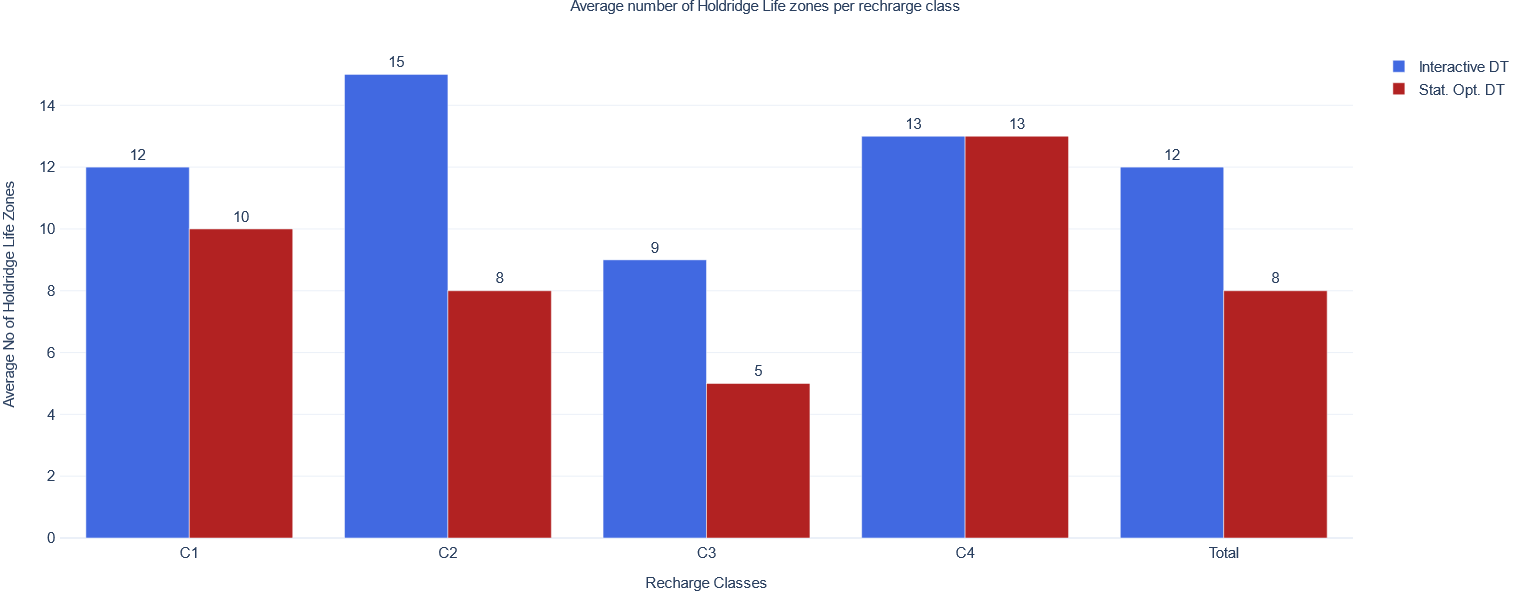

In [14]:
# Load the corresponding data:
SOT_df=pd.read_table(r'Sample_datasets\4. Random_seed_5562000\iDT_table.txt')
INT_df=pd.read_table(r'Sample_datasets\4. Random_seed_5562000\SOT_table.txt')

#Estimate the average number of diamonds per class:
SOT_Life_zones = {}
INT_Life_zones = {}

for cl in ['C1', 'C2', 'C3', 'C4']:
    SOT_Life_zones[cl]=SOT_df.loc[SOT_df.loc[:,'nodes_classes']==cl,'Holdridge Life Zones'].mean(axis=0) 
    INT_Life_zones[cl]=INT_df.loc[INT_df.loc[:,'nodes_classes']==cl,'Holdridge Life Zones'].mean(axis=0) 

Life_zones_per_class=pd.DataFrame(data=[SOT_Life_zones, INT_Life_zones] , index=['Average No of Life Zones - SOT', 'Average No of Life Zones - INT']).round(0)
Life_zones_per_class['Total']=[np.round(SOT_df['Holdridge Life Zones'].mean(),0), np.round(INT_df['Holdridge Life Zones'].mean(),0)]

#Create the plot:
Life_zones_fig=go.Figure()

Life_zones_fig.add_trace(go.Bar(x=list(Life_zones_per_class.columns), y=Life_zones_per_class.loc['Average No of Life Zones - INT', :], 
                                 name='Interactive DT',
                                 text=Life_zones_per_class.loc['Average No of Life Zones - INT', :],
                                 textposition='outside',
                                 textfont={'family':'Arial', 'size': 15},
                                 marker=dict(color='royalblue')))

Life_zones_fig.add_trace(go.Bar(x=list(Life_zones_per_class.columns), y=Life_zones_per_class.loc['Average No of Life Zones - SOT', :],
                                 name='Stat. Opt. DT',
                                 text=Life_zones_per_class.loc['Average No of Life Zones - SOT', :],
                                 textposition='outside', 
                                 textfont={'family':'Arial', 'size': 15},
                                 marker=dict(color='firebrick')))

Life_zones_fig.update_layout(autosize=False, width=1200, height=600,
                             title={'text': 'Average number of Holdridge Life zones per rechrarge class', 'y':1, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top', 
                                    'font_family':'Arial'},
                             titlefont = {'size': 15},
                             yaxis = dict(title='Average No of Holdridge Life Zones', titlefont={'family':'Arial', 'size': 15}, tickfont={'family':'Arial', 'size': 15}),
                             xaxis = dict(title='Recharge Classes', titlefont={'family':'Arial', 'size': 15}, tickfont={'family':'Arial', 'size': 15}),
                             legend = dict(font={'family':'Arial', 'size': 15}),
                             margin = go.layout.Margin(l=20,r=20,b=50,t=50,pad = 4), template='plotly_white',
                             barmode='group')

__Comments:__

This graph shows that in the case of iDTs we achieved a significant reduction in the numder of diamonds classes C2 and C3 can be mapped to. This increases DT outcome interpretability since someone can map the reacharge classes to climate zones more concisely than in SOT.

__Note: For the rest of the sample datasets of the paper I applied the same methodology to all the 15 different sample datasets.__

Having applied the same methodology for each of the sample datasets and measuring the classification accuracy on train and tests set, a barplot with their accuracies is constructed:

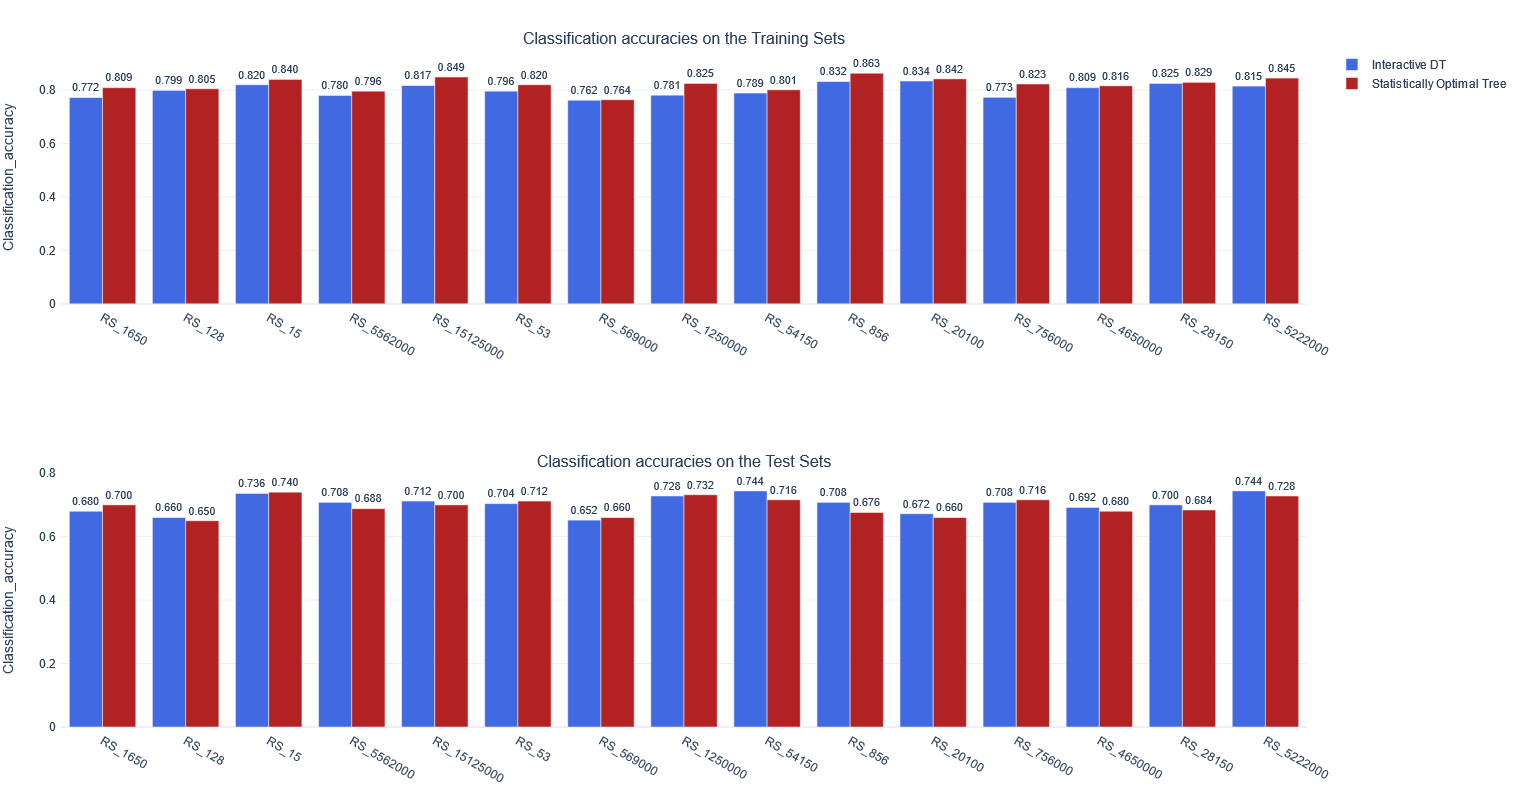

In [15]:
#Assembling the classification accuracies in one dictionary
Trees_Accuracies_sample1000={'SOT - Accuracy on Training set': [0.809, 0.805, 0.840,  0.796,  0.849, 0.820, 0.764,  0.825, 0.801, 0.863, 0.842, 0.823, 0.816, 0.829, 0.845],
                             'iDT - Accuracy on Training set': [0.772, 0.799, 0.820,  0.780,  0.817, 0.796, 0.762,  0.781, 0.789, 0.832, 0.834, 0.773, 0.809, 0.825, 0.815],
                             'SOT - Accuracy on Test set':     [0.700, 0.650, 0.740,  0.688,  0.700, 0.712, 0.660,  0.732, 0.716, 0.676, 0.660, 0.716, 0.680, 0.684, 0.728],
                             'iDT - Accuracy on Test set':     [0.680, 0.660, 0.736,  0.708,  0.712, 0.704, 0.652,  0.728, 0.744, 0.708, 0.672, 0.708, 0.692, 0.700, 0.744],
                             'Training_data_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                             'Tick_labels':['RS_1650', 'RS_128', 'RS_15', 'RS_5562000', 'RS_15125000', 'RS_53', 'RS_569000', 'RS_1250000', 'RS_54150', 'RS_856', 'RS_20100', 'RS_756000', 'RS_4650000', 'RS_28150', 'RS_5222000']}


#Derive a barplot with class. acc. for the two DT for train and test sets
Trees_s1000_fig = make_subplots(rows=2, cols=1, subplot_titles=('Classification accuracies on the Training Sets', 'Classification accuracies on the Test Sets'))


Trees_s1000_fig.append_trace(go.Bar(x=Trees_Accuracies_sample1000['Tick_labels'], y=Trees_Accuracies_sample1000['iDT - Accuracy on Training set'], 
                                    name='Interactive DT',   #iDT - Training set
                                    text=Trees_Accuracies_sample1000['iDT - Accuracy on Training set'],
                                    textposition='outside',
                                    textfont={'family':'Arial'},
                                    texttemplate='%{text:.3f}',
                                    marker=dict(color='royalblue')), row=1, col=1)

Trees_s1000_fig.append_trace(go.Bar(x=Trees_Accuracies_sample1000['Tick_labels'], y=Trees_Accuracies_sample1000['SOT - Accuracy on Training set'],
                                    name='Statistically Optimal Tree', #Stat. Opt. Tree - Training set
                                    text=Trees_Accuracies_sample1000['SOT - Accuracy on Training set'],
                                    textposition='outside', 
                                    textfont={'family':'Arial'},
                                    texttemplate='%{text:.3f}',
                                    marker=dict(color='firebrick')), row=1, col=1)

Trees_s1000_fig.append_trace(go.Bar(x=Trees_Accuracies_sample1000['Tick_labels'], y=Trees_Accuracies_sample1000['iDT - Accuracy on Test set'], 
                                    name='Interactive DT - Test set',
                                    text=Trees_Accuracies_sample1000['iDT - Accuracy on Test set'],
                                    textposition='outside',
                                    textfont={'family':'Arial'},
                                    texttemplate='%{text:.3f}',
                                    showlegend=False,
                                    marker=dict(color='royalblue')), row=2, col=1)

Trees_s1000_fig.append_trace(go.Bar(x=Trees_Accuracies_sample1000['Tick_labels'], y=Trees_Accuracies_sample1000['SOT - Accuracy on Test set'],
                                    name='Stat. Opt. Tree - Test set',
                                    text=Trees_Accuracies_sample1000['SOT - Accuracy on Test set'],
                                    textposition='outside', 
                                    textfont={'family':'Arial'},
                                    texttemplate='%{text:.3f}',
                                    showlegend=False,
                                    marker=dict(color='firebrick')), row=2, col=1)


Trees_s1000_fig.update_layout(autosize=False, width=1400, height=800,
                              font={'family':'Arial'},
                              legend = dict(font={'family':'Arial'}, orientation='v'),
                              margin = go.layout.Margin(l=20,r=20,b=50,t=50,pad = 4), template='plotly_white',
                              barmode='group')

Trees_s1000_fig.update_xaxes(titlefont={'family':'Arial'}, tickfont={'family':'Arial'}, row=1, col=1)
Trees_s1000_fig.update_xaxes(titlefont={'family':'Arial'}, tickfont={'family':'Arial'}, row=2, col=1)

Trees_s1000_fig.update_yaxes(title_text='Classification_accuracy', titlefont={'family':'Arial'}, tickfont={'family':'Arial'}, range=[0.0,0.95], row=1, col=1)
Trees_s1000_fig.update_yaxes(title_text='Classification_accuracy', titlefont={'family':'Arial'}, tickfont={'family':'Arial'}, range=[0.0,0.80], row=2, col=1)

# 6. References

- Understanding the sensitivity of karst groundwater recharge to climate and land cover changes at a large-scale, Sarrazin, F. (Author). 25 Sep 2018